In [1]:
# TODO:
# 2. Have a re-think / re-check wrt data leakage
# 3. Comment on the functions in the module. Add more explanations here. Finish the README write up including library version.

# Imports

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from src import methodology, processing, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize']=[15, 10]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams['font.size'] = '32'   # Use 22 if legend overlaps on data
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.autolayout'] = True

np.random.seed(0)
random.seed(0)

# Parameter Values

## Parameters for reading in data

In [3]:
NFFT = 2**9
DATA_ROOT_LOC = '../../../data/'            # Where data is located relative to current notebook file
NUM_DATA_IN_DIR = 400

Bridge_Type = 'B09'                          # B09 | B15 | B21 | B27 | B33 | B39
Damage_Location = 'DL25'                     # DL25 | DL50
Damage_Levels = ['DM00', 'DM20', 'DM40']     # DM00 ("Healthy") | DM20 | DM40
Vehicle_Type = 'V1'                          # V1 | V2 | V5
Bridge_Profile = 'P00'                       # P00 | PA1 | PA2

DOF_NUM = 2 # Vehicle V1 has 2 DOF

## (Hyper)Parameters for data pipeline

In [4]:
n_components = 2
n_neighbors = 60 # 30 is good
min_dist = 0
set_op_mix_ratio = 0.90
total_obs = 2
min_cluster_size = 95
sample_times = 1000 # 3000

--------

-----------

----------

# Preprocessing Code

## Reading in Data

In [5]:
data = utils.read_data_fft(Bridge_Type, Damage_Location, Vehicle_Type, Bridge_Profile,
                    NUM_DATA_IN_DIR = NUM_DATA_IN_DIR , 
                    DATA_ROOT_LOC = DATA_ROOT_LOC, 
                    NFFT=NFFT)

Processed Event 50 from damage level DM00
Processed Event 100 from damage level DM00
Processed Event 150 from damage level DM00
Processed Event 200 from damage level DM00
Processed Event 250 from damage level DM00
Processed Event 300 from damage level DM00
Processed Event 350 from damage level DM00
Processed Event 400 from damage level DM00

Processed Event 50 from damage level DM20
Processed Event 100 from damage level DM20
Processed Event 150 from damage level DM20
Processed Event 200 from damage level DM20
Processed Event 250 from damage level DM20
Processed Event 300 from damage level DM20
Processed Event 350 from damage level DM20
Processed Event 400 from damage level DM20

Processed Event 50 from damage level DM40
Processed Event 100 from damage level DM40
Processed Event 150 from damage level DM40
Processed Event 200 from damage level DM40
Processed Event 250 from damage level DM40
Processed Event 300 from damage level DM40
Processed Event 350 from damage level DM40
Processed Ev

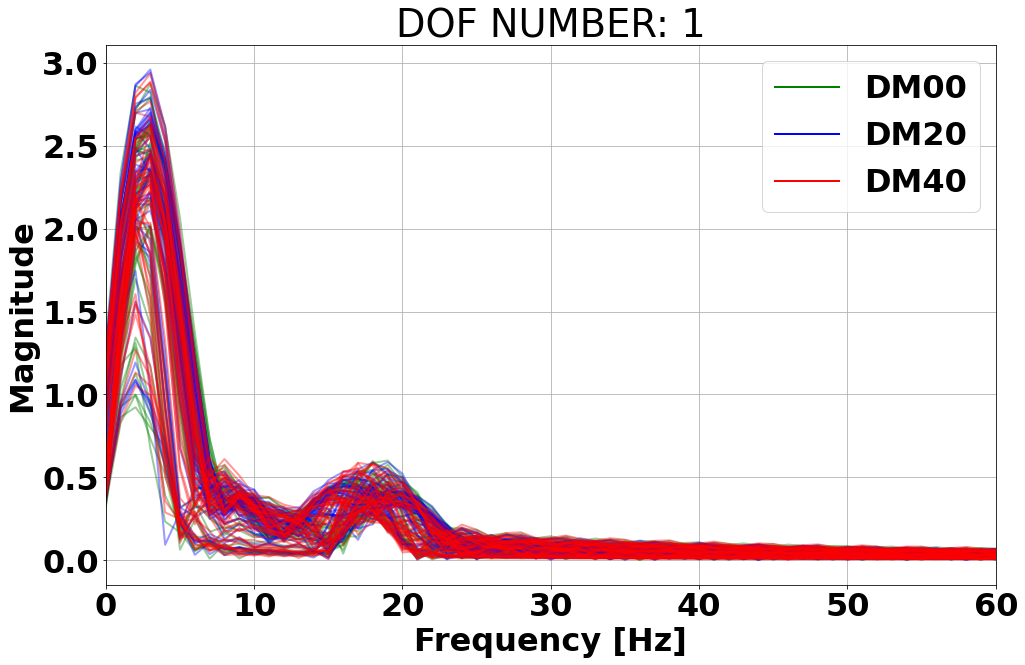

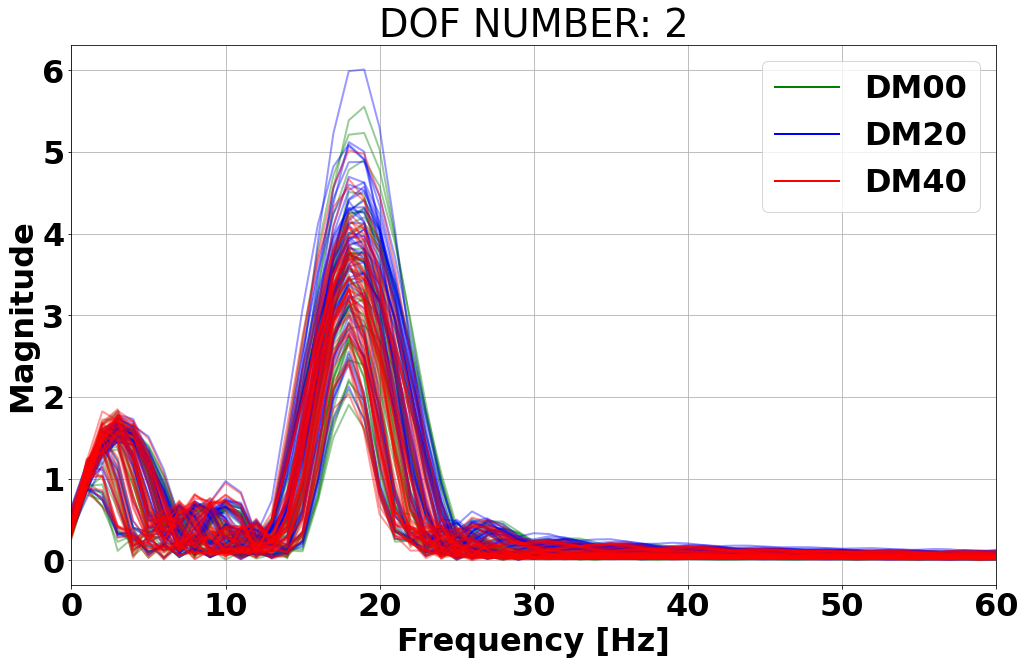

In [6]:
plt_flag_data = True
for dof in range(DOF_NUM):
    
    if plt_flag_data:
        plt.figure()
        # If you intend to plot other parts further on
        # Then please ensure the following code *is* run. 
        # It helps with the labelling of the plot in a loop.
        #######################
        label_healthy = ['DM00'] 
        label_moderate = ['DM20']
        label_large = ['DM40']
        for i in range(1,50):
            label_healthy += [None]
            label_moderate += [None]
            label_large += [None]
        #########################

        # FFT only
        plt.title(f'DOF NUMBER: {dof+1}')
        # We take columns 1 --> end, because there is a 'zero' occuring at index 0
        plt.plot(abs(data[dof]['DM00'][0:50,1:].T),'g', alpha = 0.4, label = label_healthy);
        plt.plot(abs(data[dof]['DM20'][0:50,1:].T),'b', alpha = 0.4, label = label_moderate);
        plt.plot(abs(data[dof]['DM40'][0:50,1:].T),'r', alpha = 0.4, label = label_large);
        cols = abs(data[dof]['DM00'][:,1:].T).shape[1]


        plt.xlim([0,60]) # Cut Off Frequency
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

## Analyzing the effect of bootstraping 

It is assumed here that we know which data is DM00, DM20, DM40. This is for demonstration purposes, in the actual code, it won't be known which data is which

In [7]:
DOF_NUM

2

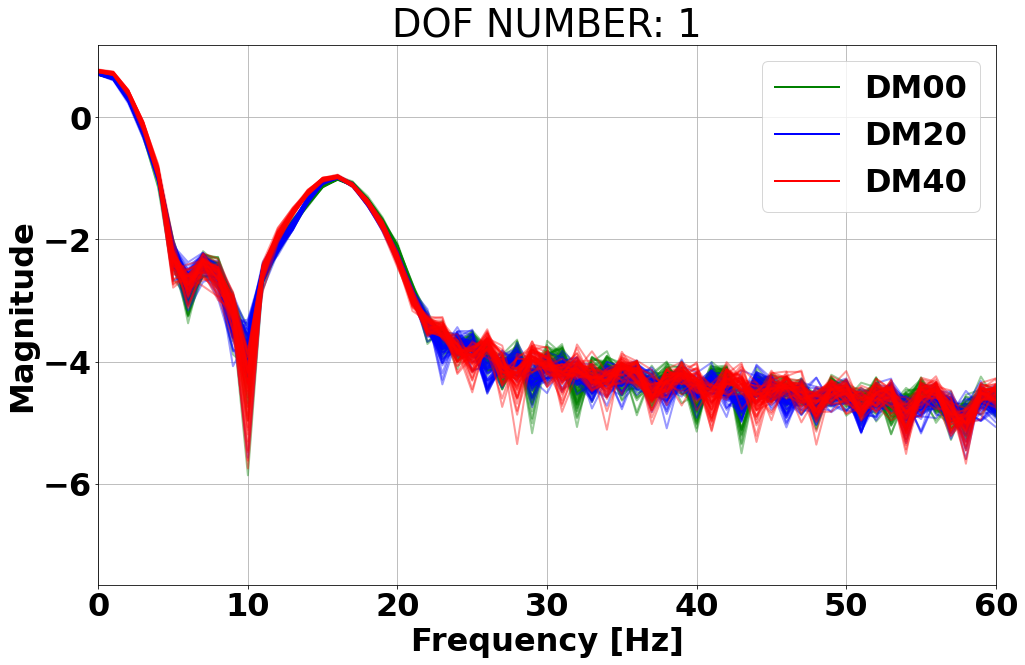

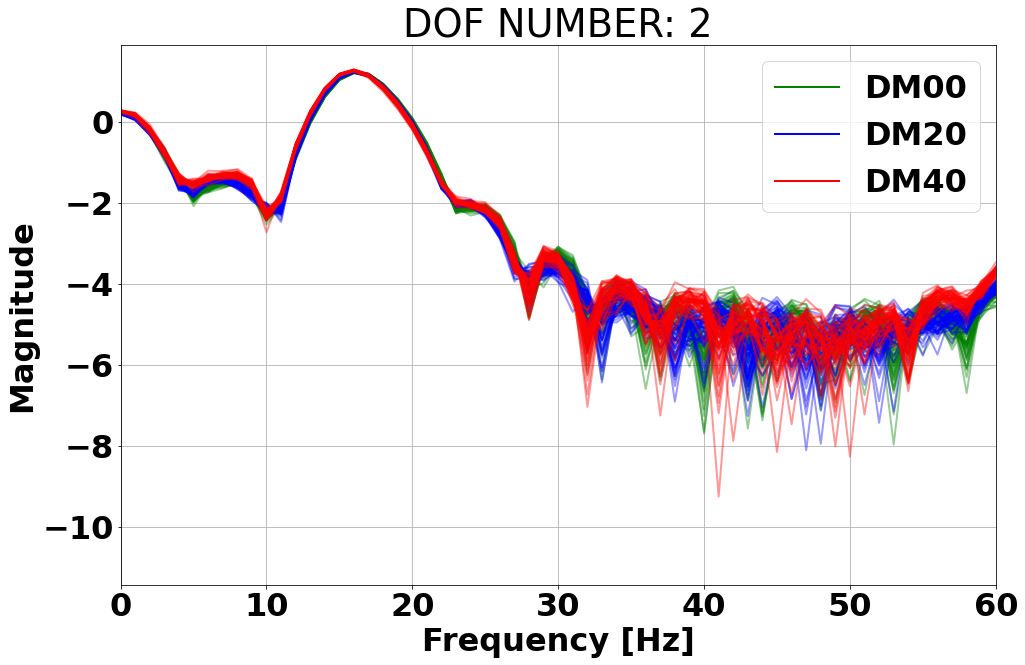

In [8]:
plt_flag_data = True

transformed = []
for dof in range(DOF_NUM):
    
    transformed.append({})
    if plt_flag_data:
        plt.figure()
        healthy_data_fft = data[dof]['DM00']
        mod_data_fft = data[dof]['DM20']
        large_data_fft = data[dof]['DM40']

        # Perform bootstrapping
        healthy_bootstrap = processing.bootstrap_sampling(healthy_data_fft, sample_times=sample_times) 
        mod_bootstrap = processing.bootstrap_sampling(mod_data_fft, sample_times=sample_times) 
        large_bootstrap = processing.bootstrap_sampling(large_data_fft, sample_times=sample_times) 

        healthy_log_abs_train = processing.log_abs_transform(healthy_bootstrap[0])
        mod_log_abs_train = processing.log_abs_transform(mod_bootstrap[0])
        large_log_abs_train = processing.log_abs_transform(large_bootstrap[0])

        plt.title(f'DOF NUMBER: {dof+1}')
        plt.plot(healthy_log_abs_train[0:50,3:].T,'g', label = label_healthy, alpha = 0.4);
        plt.plot(mod_log_abs_train[0:50,3:].T,'b', label = label_moderate, alpha = 0.4);
        plt.plot(large_log_abs_train[0:50,3:].T,'r', label = label_large, alpha = 0.4);
        plt.xlim([0,60])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')

        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
        transformed[dof]['DM00'] = healthy_log_abs_train[:,3:]
        transformed[dof]['DM20'] = mod_log_abs_train[:,3:]
        transformed[dof]['DM40'] = large_log_abs_train[:,3:]

## Demonstration of Standard Scaling effect

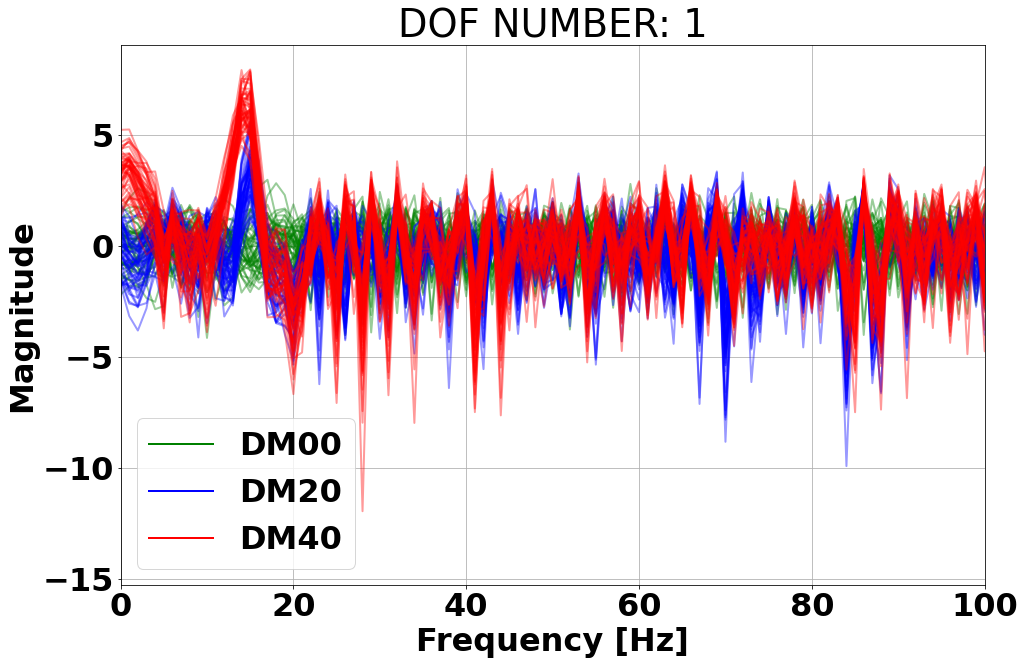

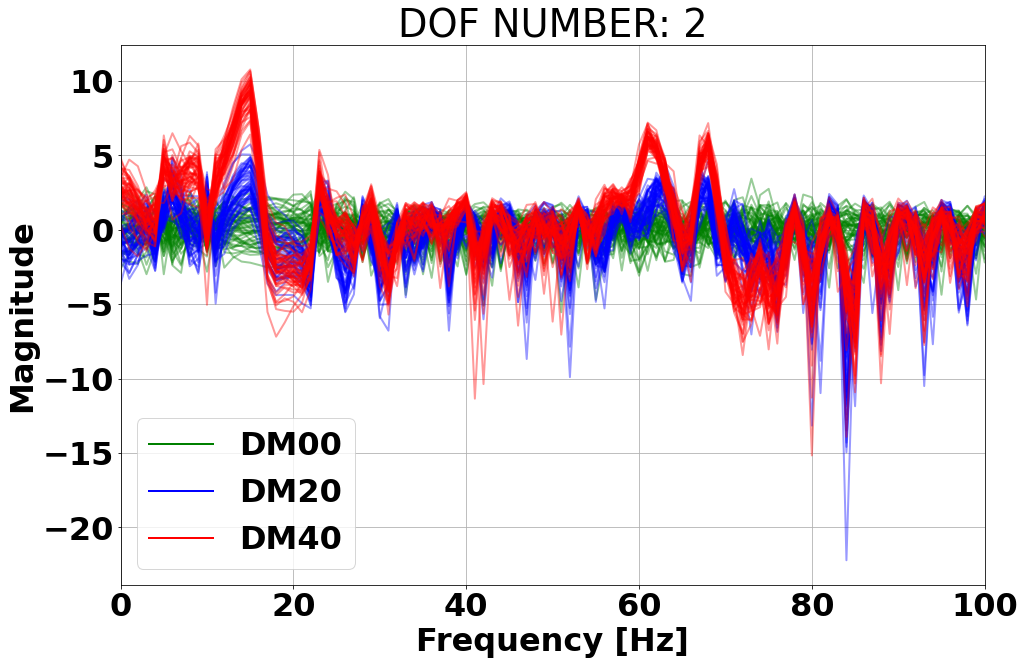

In [9]:
plt_flag_data = True
scaled = []

for dof in range(DOF_NUM):
    
    scaled.append({})
    if plt_flag_data:
        plt.figure()
        scaler = StandardScaler()
        healthy_scaled = scaler.fit_transform(transformed[dof]['DM00']) #### You NEED TO MAKE SURE THIS SPLIT IS CONSISTENT E.G. WHEN INPUTING THE DATASTREAMS SEQUENCING
        mod_scaled = scaler.transform(transformed[dof]['DM20'])
        large_scaled = scaler.transform(transformed[dof]['DM40'])
        
        plt.title(f'DOF NUMBER: {dof+1}')
        plt.plot(healthy_scaled[0:50,:].T,'g', label = label_healthy, alpha = 0.4);
        plt.plot(mod_scaled[0:50,:].T,'b', label = label_moderate, alpha = 0.4);
        plt.plot(large_scaled[0:50,:].T,'r', label = label_large, alpha = 0.4);

        plt.xlim([0,100])
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Magnitude')

        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
        scaled[dof]['DM00'] = healthy_scaled[:,:100]
        scaled[dof]['DM20'] = mod_scaled[:,:100]
        scaled[dof]['DM40'] = large_scaled[:,:100]

------

-------

------

# Running UMAP $\rightarrow$ HDBSCAN Algorithm

This is to be run on the *transformed* data as per above. In this code it therefore assumes that all plots are run (because the data is pre-processing in each instance).

Note also that this function takes n_healty, n_mod, and n_large as inputs. It must be stressed that *these are not used* in the algorithm -- they are simply there to assist in the colors when plotting. The only input ever being using is that of the *total stacked data*.

Looking at the previous scaling, the ```fit-transform``` was perform directly on the healthy, and the ```transform``` on the modeerate (DM20), and then large (DM40) cases. This may initially come across as a data leakage problem, but in fact this is not the case. Because we operate under the assumption that the first X amount of days / weeks / months, the bridge should be operating within a healthy state, and therefore it is OK to perform a fit-transform here. From there-onwards, it is appropriate to continually apply the t```ransform``` only regardless of the health state (because if it is still healthy, the data will map to the same space, and if it contains damage, it will map to a different location). 

This option can be explored through a hyperparameter in the ```HDBSCAN_UMAP_Application``` function via ```total_obs```. This hyperparameter works to partition the stacked data into distinct observation sets e.g. by default ```total_obs=2```, so we assume that the total data stack is split into two, so the first half will contain DM00 and DM20 data, whilst the second half will contain a mixture of DM20, and DM40 data. 

In a practical implementation, the scalar transformations *should* be more ideally performed within the ```HDBSCAN_UMAP_Application``` function (transform the data live -- as it is being received) but for the sake of demonstration (i.e. clearly separating out the steps), this has been externalized from the function in the above step.

Note that even though there are 400 data in directory, beacuse we are over sampling (using the boot-strap like procedure) the ```n_healthy```, ```n_mod```, ```n_large``` will be the same as the ```sample_times``` chosen. 

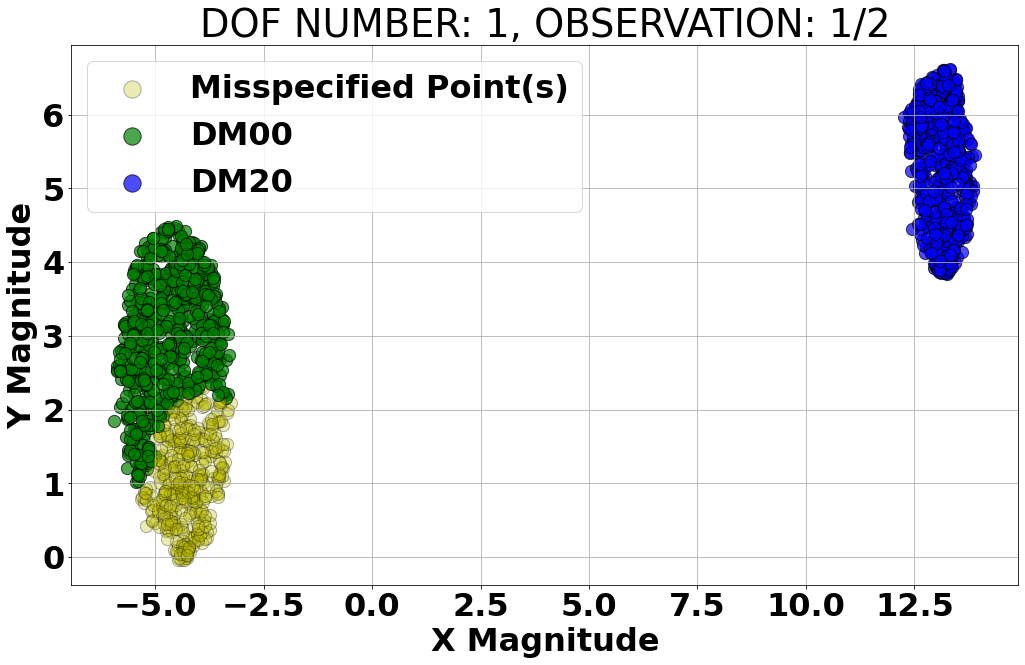

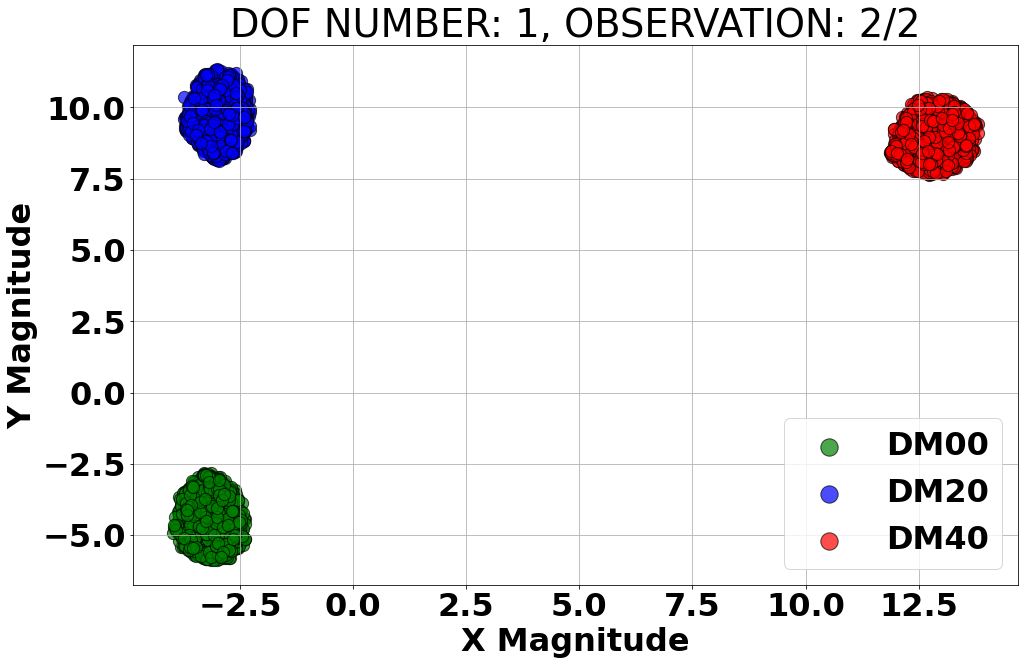

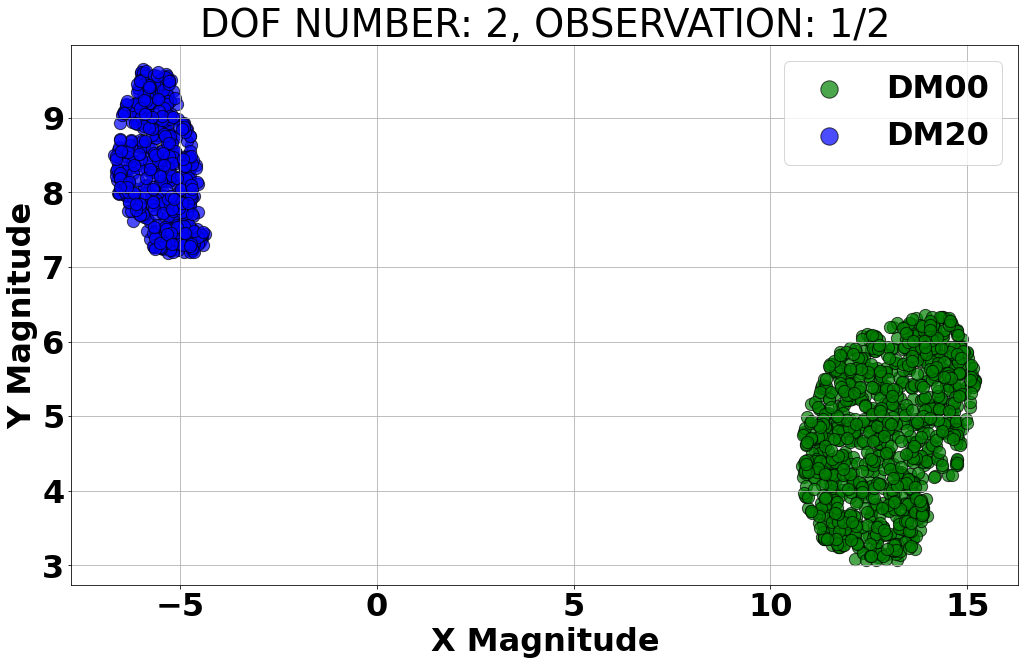

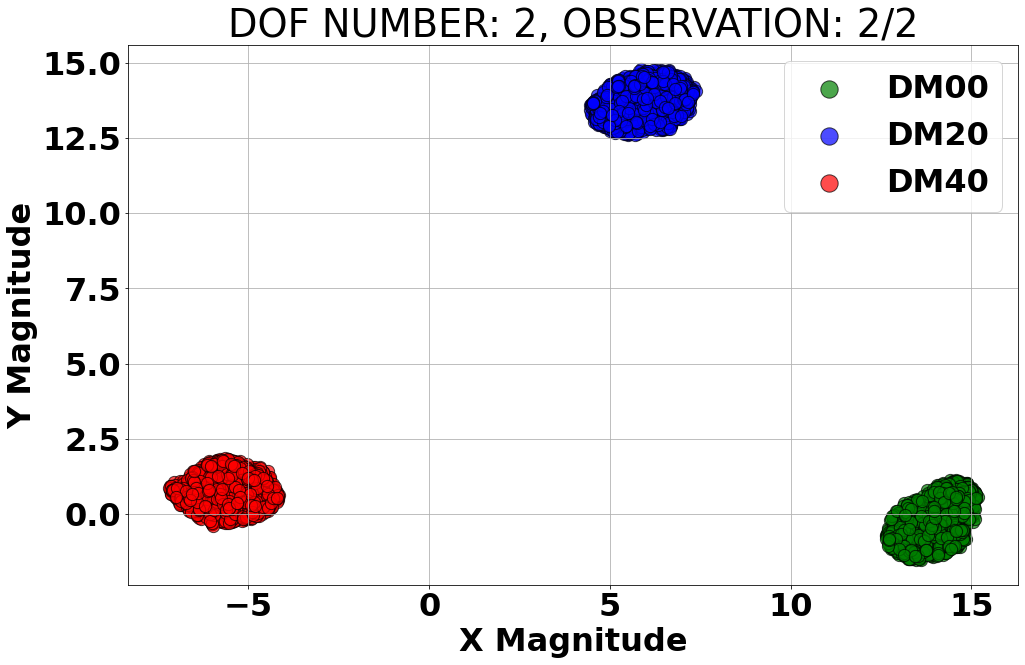

In [10]:
n_healthy, n_mod, n_large = sample_times, sample_times, sample_times
for dof in range(DOF_NUM):
    total_data = np.vstack((scaled[dof]['DM00'], scaled[dof]['DM20'], scaled[dof]['DM40']))
    methodology.HDBSCAN_UMAP_Application(total_data, n_healthy, n_mod, n_large, dof, plot_flag = True,
                                        set_op_mix_ratio=0.9)

Note that it is also possible to check the results obtained by the proposed procedure against theoretical results. That is, by performing the UMAP projection *only*, and then assigning a color to each row, with the knowledge that *we know* which cluster each row belongs to. This can be achieved using the following code. 

This time instead however, we shall set the ```total_obs``` value to 5. In other words, our stack of data arrives to us in 5 discrete increments / time observations. 

Note also that the UMAP embeddings between the ```theoretical_clustering``` and ```HDBSCAN_UMAP_Application``` functions may not always necessarily be to the same locations, since the random seed slightly changes as we move from one function on to the next. What's important however, is that if separability exists in one function, it should also exist in the other function. 

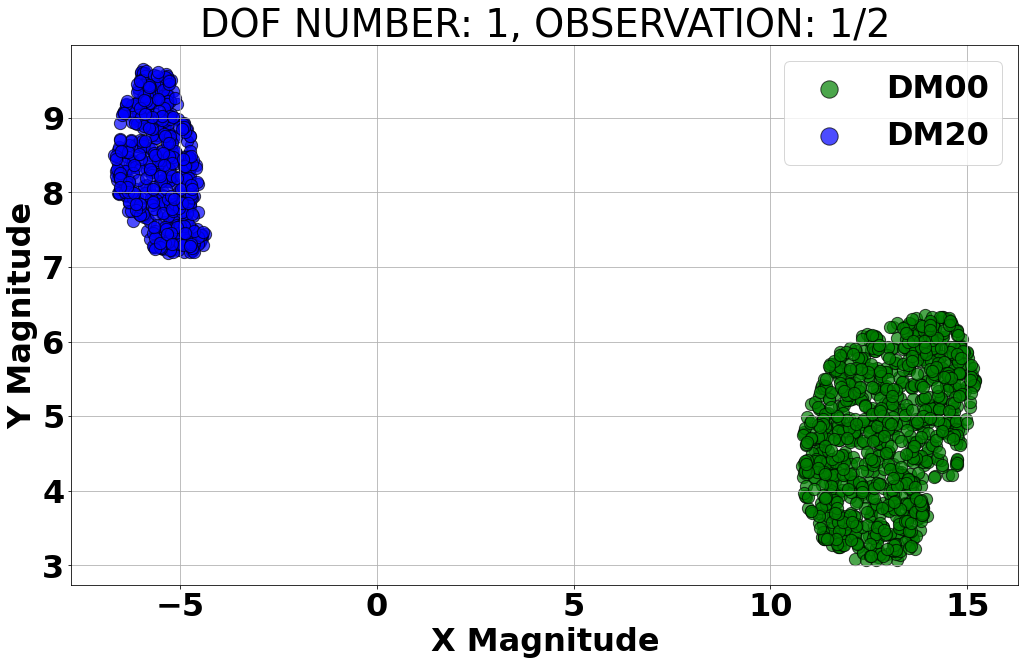

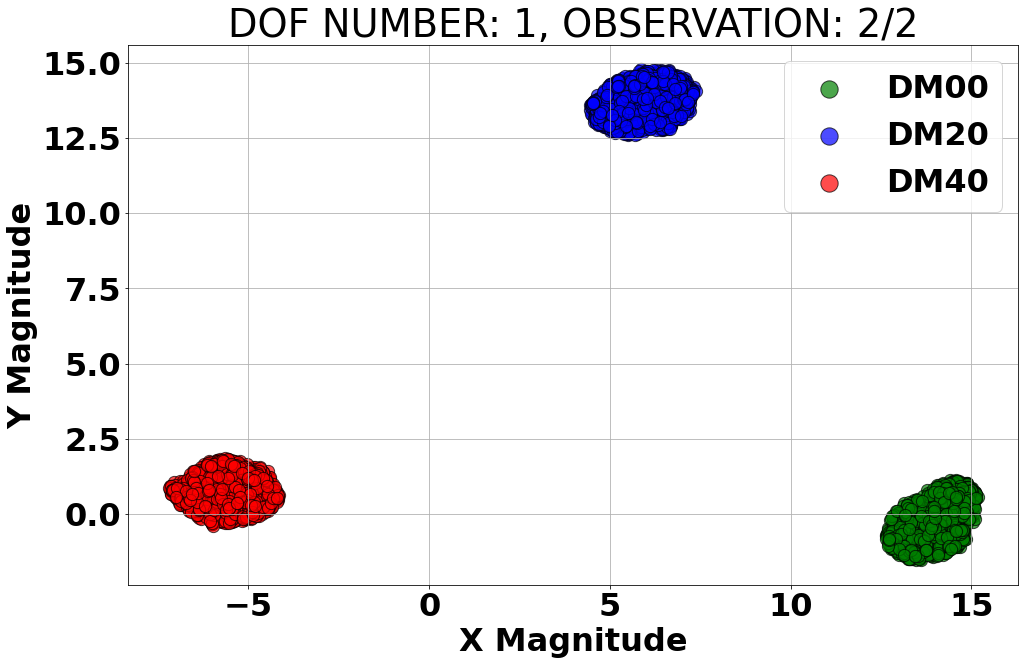

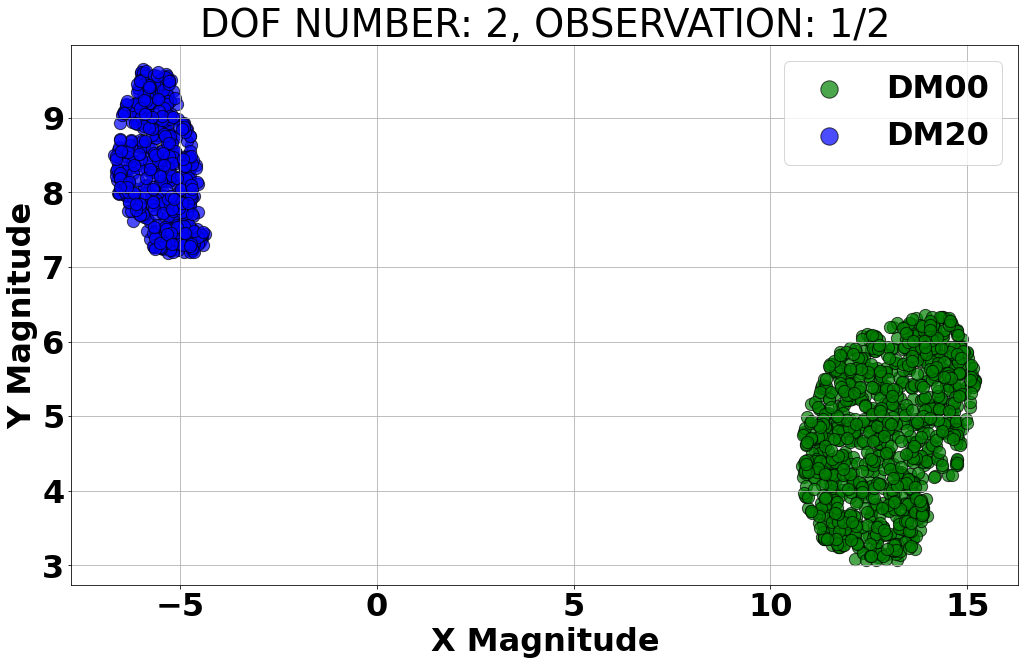

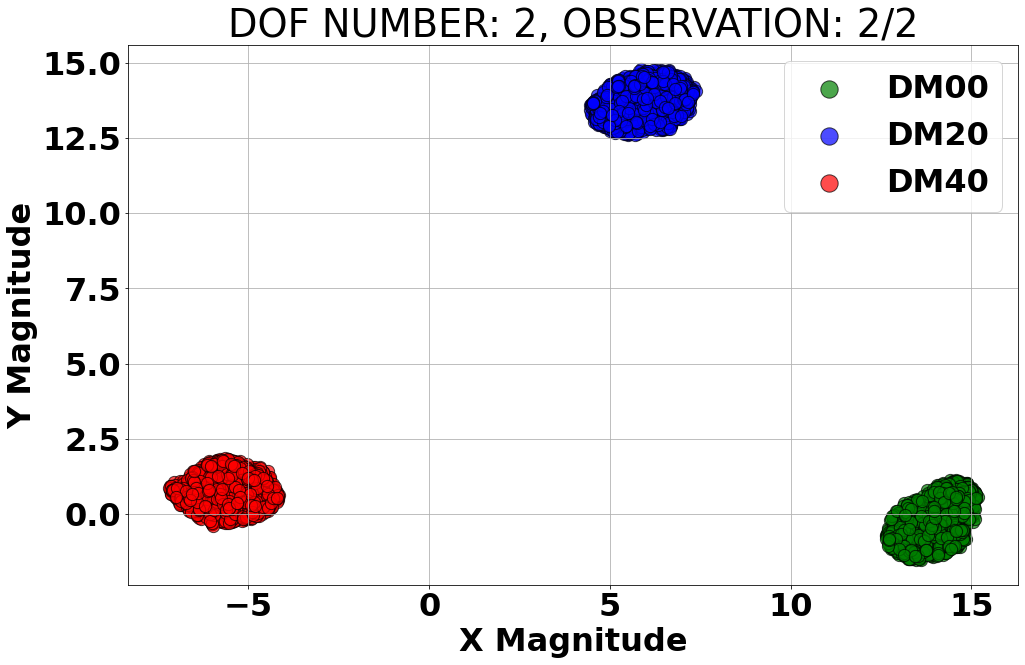

In [11]:
for dof in range(DOF_NUM):
    methodology.theoretical_clustering(total_data, n_healthy, n_mod, n_large, dof, plot_flag = True, total_obs = 2,
                                      set_op_mix_ratio=0.9)

-------

------

------

# Conclusion / Future Work

As can be seen above for the provided case of P00 - V01 - B09 - DL50, the data pipeline successfully spearates out each of the damage cases quite easily. The *exact* same hyper-parameters have been also shown to work on the following data cases:

 - P00 - V01 - B09 - DL25
 - PA1 - V01 - B09 - DL50
 - PA1 - V01 - B09 - DL25
 - PA2 - V01 - B09 - DL50
 
There is however a slight difficulty when it comes to the case of PA2 - V01 - B09 - DL25 (DOF1), and hyper-parameter tuning will be required on behalf of the user. A quick solution (based on observation) is to 

 1. Increase ```n_neighbors``` to a value of 60 so as to increase the *diameter* the UMAP scans for clusters, 
 2. Increase ```min_cluster_size``` to a value of 95 for similar reasons, 
 3. Decrease ```set_op_mix_ratio``` to a value of 0.90, to slightly enforce further separation between any clusters found in the dimensionality reduction, and to 
 4. Increase ```sample_times``` to a value of 3000, to try and allow for the clusters to increase in overall density. 

It will be noted that even then, there is some "overlap" over data points so that they can be slightly mis-specified (i.e. the probability of allocation between clusters approaches an even split, so in the event of two clusters this would be a 50%). Any true mis-allocations of points can be shown easily via ```theoretical_clustering``` function. However these points will be *greyed-out* in the ```HDBSCAN_UMAP_Application``` function (moreover outlier points as determined from HDBSCAN will also be labelled). If one wants these not to be shown then one can set the ```remove_outliers``` and ```remove_misspec``` hyperparameters to ```True```. The method to determine these points is currently not optimal and based on determining the *mode*

Further, the projections for V01 - B09 were done to two dimensional space, for visual purposes. If the problem increases in complexity, then it may be necessary to increase ```n_components``` to a value greater than two.

We hope this work inspires further development 